In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train[0].shape

(28, 28)

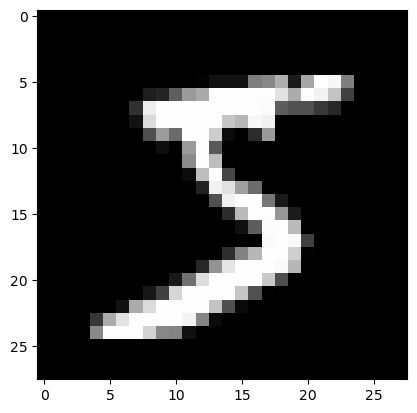

In [4]:
plt.imshow(X_train[0], cmap='gray')

In [5]:
y_train[0]

5

In [6]:
pd.Series(y_train).value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64

In [7]:
import torch.nn as nn

class CNNModel(nn.Module):
    
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        #If RGB feature maps, in_channels=3
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*7*7, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)
        #If binary classification, last layer outputs 2 values
        
    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.conv4(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        x = nn.functional.softmax(x, dim=1)
        #If binary classification, last layer uses nn.functional.sigmoid
        return x

In [8]:
from skorch.classifier import NeuralNetClassifier
import torch

model = NeuralNetClassifier(module=CNNModel, device='cuda' if torch.cuda.is_available() else 'cpu')
#If binary classification, nn_model uses NeuralNetBinaryClassifier 

In [9]:
X_train = X_train/255
X_test = X_test/255

In [10]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

In [11]:
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

In [12]:
X_train[0].shape

torch.Size([1, 28, 28])

In [13]:
model.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.3002       0.1268        2.2961  11.9203
      2        2.1500       0.6634        1.0393  5.0261
      3        0.7556       0.8817        0.3857  4.9536
      4        0.4326       0.9247        0.2490  7.4868
      5        0.3093       0.9458        0.1806  7.9974
      6        0.2416       0.9565        0.1429  8.3540
      7        0.2023       0.9619        0.1217  7.8323
      8        0.1778       0.9662        0.1065  7.6782
      9        0.1578       0.9714        0.0941  8.3108
     10        0.1444       0.9731        0.0918  8.1145


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=CNNModel(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout1): Dropout(p=0.25, inplace=False)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout2): Dropout(p=0.25, inplace=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=3136, out_features=256, bias=True)
    (dropout3): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=256, out_features=10, bias=True)
  ),
)

In [14]:
y_test_pred = model.predict(X_test)
y_test_pred

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.98      0.95      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.95      0.98      0.96       892
           6       0.98      0.97      0.98       958
           7       0.97      0.98      0.97      1028
           8       0.97      0.96      0.97       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [16]:
confusion_matrix(y_test,y_test_pred)

array([[ 971,    0,    1,    0,    0,    1,    3,    1,    3,    0],
       [   0, 1127,    4,    0,    0,    0,    1,    1,    2,    0],
       [   7,    1, 1000,    8,    1,    0,    1,    7,    7,    0],
       [   0,    0,    6,  960,    0,   25,    0,    8,    7,    4],
       [   0,    1,    2,    0,  958,    0,    6,    1,    2,   12],
       [   2,    0,    0,    3,    1,  878,    3,    2,    1,    2],
       [  10,    4,    0,    0,    3,    7,  933,    0,    1,    0],
       [   1,    4,   11,    0,    0,    0,    0, 1003,    1,    8],
       [   5,    0,    1,    4,    4,   11,    2,    7,  937,    3],
       [   5,    7,    0,    3,   14,    6,    0,    7,    3,  964]],
      dtype=int64)

In [17]:
y_test_pred_proba = model.predict_proba(X_test)
y_test_pred_proba

array([[4.99252995e-09, 1.31151778e-09, 1.54875329e-06, ...,
        9.99993324e-01, 8.47942445e-08, 1.05030404e-06],
       [3.77658523e-07, 1.89874467e-04, 9.99774635e-01, ...,
        1.94774574e-09, 3.22580178e-07, 3.22411759e-12],
       [5.51156154e-06, 9.99316454e-01, 4.93032967e-05, ...,
        1.06273146e-04, 2.98806292e-04, 2.28915906e-05],
       ...,
       [2.83569175e-11, 2.90204460e-09, 3.01704273e-10, ...,
        3.76477146e-06, 1.85029239e-06, 9.70348890e-04],
       [8.91371747e-06, 1.08421439e-07, 1.34906927e-07, ...,
        6.16893061e-08, 4.68455022e-03, 3.44795801e-08],
       [1.24523895e-05, 5.41444556e-10, 5.95193626e-07, ...,
        8.25748844e-11, 3.49863598e-07, 8.97555630e-09]], dtype=float32)

Text(0.5, 1.0, 'Receiver Operating Characteristic - CNNClassifier (Tensorflow)')

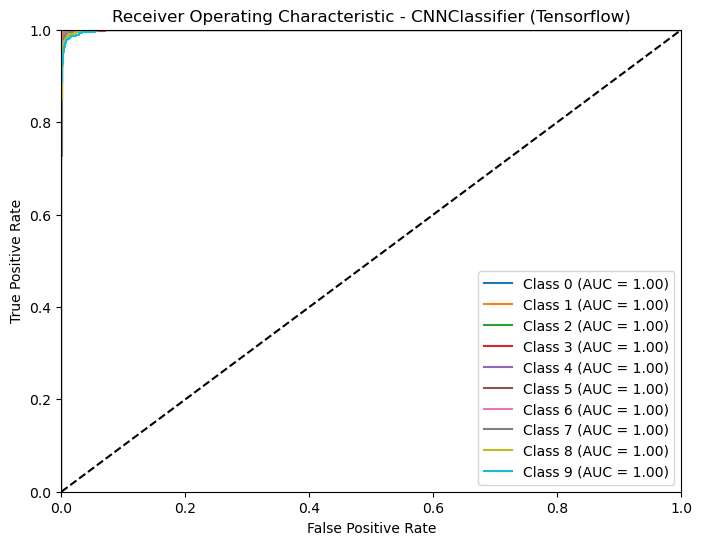

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(8, 6))
for class_idx in range(len(model.classes_)):
    y_true = (y_test == model.classes_[class_idx]).astype(int)
    y_pred_proba = y_test_pred_proba[:, class_idx]
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f'Class {model.classes_[class_idx]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - CNNClassifier (Tensorflow)')